## Requisição API usando Pandas

Documentação: https://brapi.dev/docs/acoes/list#search-opcional

### 1- Imports

In [ ]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2- Consumindo dados da API

In [ ]:
url = 'https://brapi.dev/api/quote/list?'

params = {
    'token': '9jn91uehisPg1z8UmRKv3J',
    'sortBy': 'volume',
    'sortOrder': 'desc'
}
response = requests.get(url, params=params)
data = response.json()['stocks']

df = pd.DataFrame(data)

### 3- Limpando e preparando dados

In [ ]:
df.info()          # Visualização geral dos dados contidos no DF
df.isnull().sum()  # Verificação de quais colunas contem dados que estão nulos e a quantidade

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   stock       1664 non-null   object 
 1   name        1664 non-null   object 
 2   close       1664 non-null   float64
 3   change      1664 non-null   float64
 4   volume      1664 non-null   int64  
 5   market_cap  1120 non-null   float64
 6   logo        1664 non-null   object 
 7   sector      1250 non-null   object 
 8   type        1664 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 117.1+ KB
Out[3]: stock           0
name            0
close           0
change          0
volume          0
market_cap    544
logo            0
sector        414
type            0
dtype: int64

#### 3.1- Coluna Change

In [ ]:
df[df['change'].isnull()]           # Vizualizando as linhas com valores nulos da coluna 'Change'
df = df.dropna(subset=['change'])   # Removi apenas os nulos da coluna 'Change'

#### 3.2- Coluna Type

In [ ]:
# Verificando quais valores a coluna type tem
df['type'].unique()

# Gerando dicionário com os valores verificados acima e as respectivas traduções
dict_type = {'stock': 'acao', 'fund': 'fundo', 'bdr': 'bdr'}

# Sobrescrevendo o DF com os valores do dicionário
df['type'] = df['type'].map(dict_type)

#### 3.3- Coluna Sector

In [ ]:
# Rodei essa linha com os 3 tipos de papeis, e como a coluna 'sector' será importante apenas para 'Acoes' e nessa configuração não possui valores Nulos, decidi não tratá-los
df[df['sector'].isnull() & (df['type'] == 'Acao')]

# Fiz o mesmo tratamento da coluna Type
df['sector'].unique()

dict_sector = {
    'Retail Trade': 'Comércio Varejista', 'Health Services': 'Serviços de Saúde', 'Finance': 'Finanças', 'Non-Energy Minerals': 'Minerais Não Energéticos', 'Energy Minerals': 'Minerais Energéticos', 'Consumer Non-Durables': 'Bens de Consumo Não Duráveis', 'Technology Services': 'Serviços de Tecnologia', 'Commercial Services': 'Serviços Comerciais', 'Utilities': 'Serviços Públicos',
    'Transportation': 'Transporte', 'Consumer Services': 'Serviços ao Consumidor', 'Process Industries': 'Indústrias de Processo', 'Miscellaneous': 'Diversos', 'Distribution Services': 'Serviços de Distribuição', 'Producer Manufacturing': 'Manufatura de Produtores', 'Electronic Technology': 'Tecnologia Eletrônica', 'Health Technology': 'Tecnologia de Saúde', 'Communications': 'Comunicações', 'Industrial Services': 'Serviços Industriais', 'Consumer Durables': 'Bens de Consumo Duráveis'
}

df['sector'] = df['sector'].map(dict_sector)

#### 3.4- Coluna Stock

In [ ]:
df = df[(~df['stock'].str.endswith('F'))]

### 4- Gerando graficos

#### 4.1- Questões Gerais 

**1- Quantos papeis tem por cada setor e tipo de papel? (Ação, BDR, Fundo)**

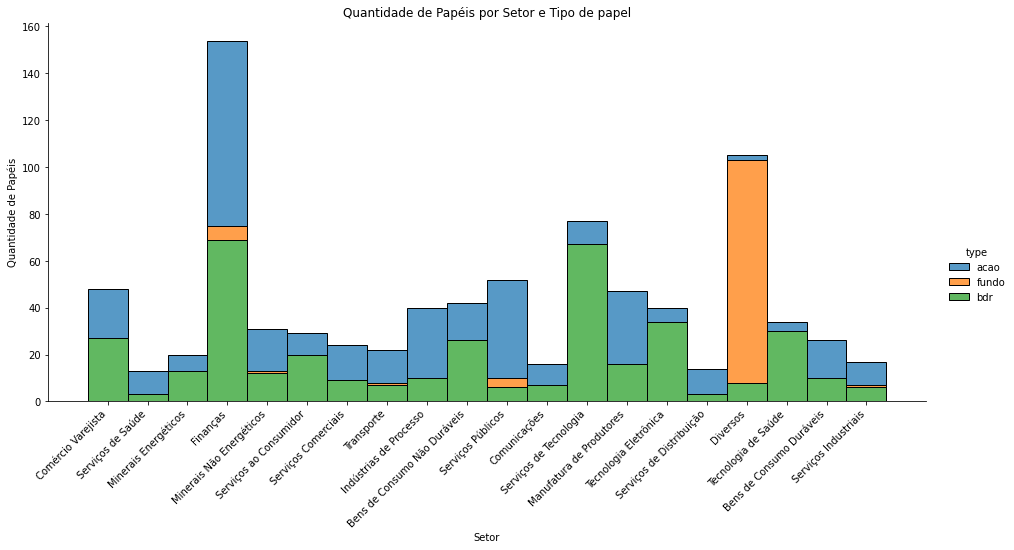

In [ ]:
sns.displot(df, x="sector", hue='type', aspect=2.2, height=6 ,multiple="stack")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Setor')
plt.ylabel('Quantidade de Papéis')
plt.title('Quantidade de Papéis por Setor e Tipo de papel')
plt.show()

**2- Qual a variação percentual dos papéis por tipo?**


- Aqui é possivel verificar os '_outliers_' de variação percentual para cada tipo de papel. Para garantir uma boa vizualização, fixei o range de visualização para 40 pontos percentuais **(de -20% a 20%)**, para papéis que utrapassem esse valor percentual será realizado outras análises abaixo.

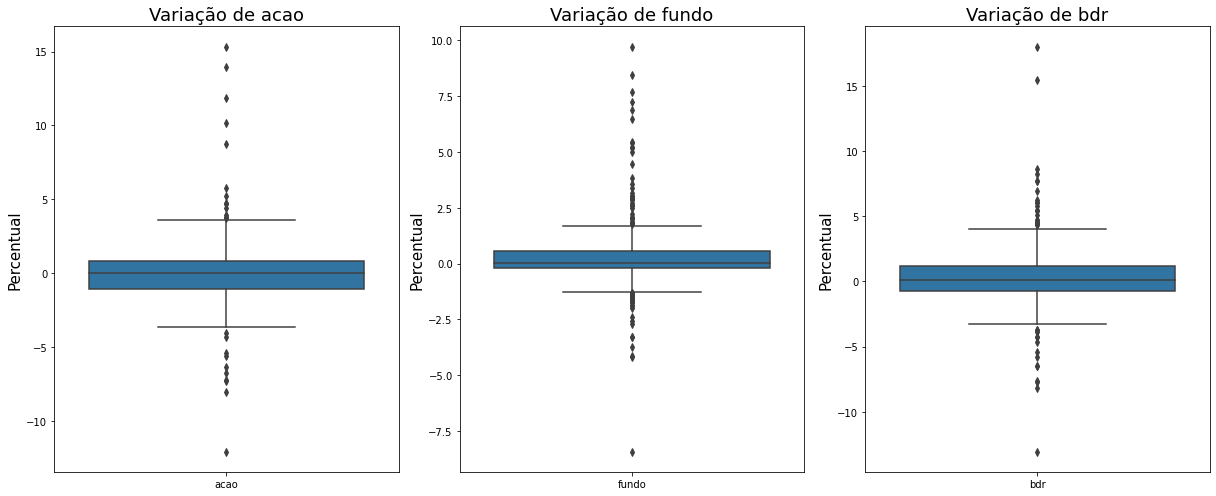

In [ ]:
types = df['type'].unique()
df_clean = df[(df['change'] <= 20) & (df['change'] >= -20)]

fig, axes = plt.subplots(1, len(types), figsize=(17,7))

for i, t in enumerate(types):
    sns.boxplot(data=df_clean[df_clean['type'] == t], x='type', y='change', ax=axes[i])
    axes[i].set_title(f'Variação de {t}', fontsize=18)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Percentual', fontsize=15)

# Ajustar o layout
plt.tight_layout()
plt.show()

**3- Qual a média de negociação dentro de cada setor?**

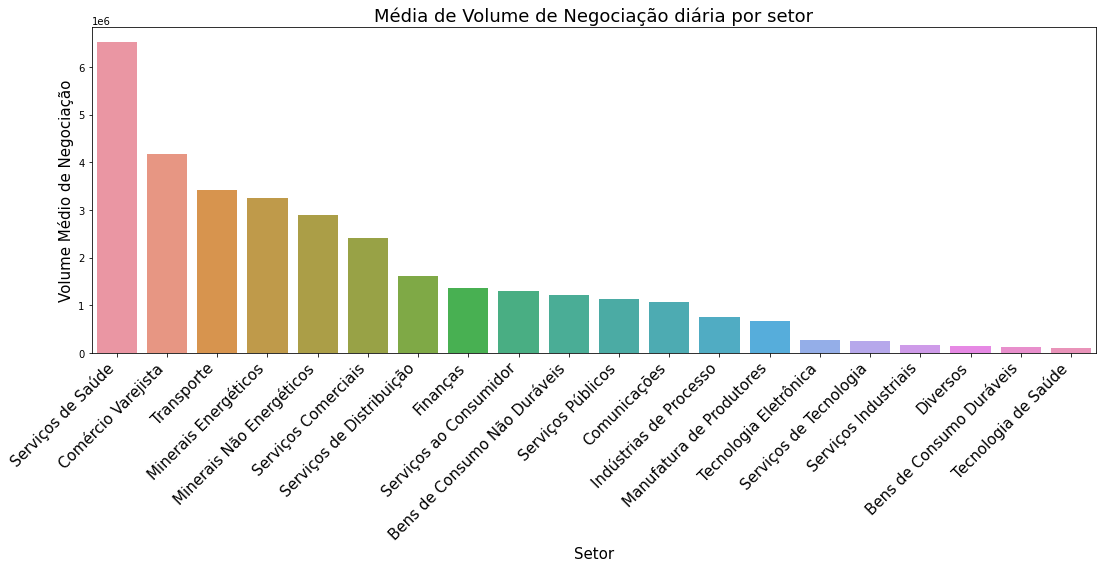

In [ ]:
df_clean = df.groupby('sector')['volume'].mean().reset_index()
order = df_clean.sort_values('volume', ascending=False)['sector']

plt.figure(figsize=(18, 6))
sns.barplot(data=df_clean, x='sector', y='volume', order=order)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.xlabel('Setor', fontsize=15)
plt.ylabel('Volume Médio de Negociação', fontsize=15)
plt.title('Média de Volume de Negociação diária por setor', fontsize=18)
plt.show()

**4- Qual a disposição dos dados das colunas 'volume', 'close' e 'market_cap'?**

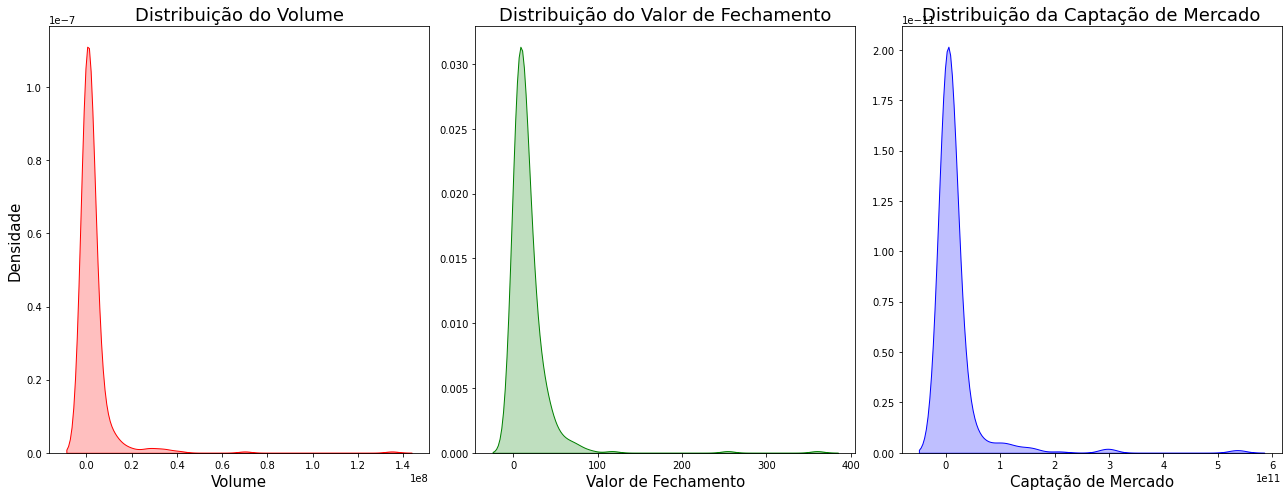

In [ ]:
df_clean = df[(df['type'] == 'acao')]

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

sns.kdeplot(data=df_clean['volume'], shade=True, color='r', ax=axes[0])
axes[0].set_title('Distribuição do Volume', fontsize=18)
axes[0].set_xlabel('Volume', fontsize=15)
axes[0].set_ylabel('Densidade', fontsize=15)

sns.kdeplot(data=df_clean['close'], shade=True, color='g', ax=axes[1])
axes[1].set_title('Distribuição do Valor de Fechamento', fontsize=18)
axes[1].set_xlabel('Valor de Fechamento', fontsize=15)
axes[1].set_ylabel('')

sns.kdeplot(data=df_clean['market_cap'], shade=True, color='b', ax=axes[2])
axes[2].set_title('Distribuição da Captação de Mercado', fontsize=18)
axes[2].set_xlabel('Captação de Mercado', fontsize=15)
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()